In [2]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 40)
pd.set_option('display.width', 500)

UsageError: Line magic function `%` not found.


In [27]:
portfolio = pd.read_json('../input/portfolio.json', orient='records', lines=True)
profile = pd.read_json('../input/profile.json', orient='records', lines=True)
transcript = pd.read_json('../input/transcript.json', orient='records', lines=True)

In [28]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['became_member_year'] = pd.DatetimeIndex(profile['became_member_on']).year
profile['gender'] = profile['gender'].fillna('N')
profile['income'] = profile['income'].fillna(profile['income'].median())

In [29]:
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 120]
group_names = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', 'Missing']
profile['age_categories'] = pd.cut(profile['age'], bins, labels=group_names)

In [30]:
bins = [29999, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000]
labels = ['30k-39k', '40k-49k', '50k-59k', '60k-69k', '70k-79k', '80k-89k', '90k-99k', '100k-109k', '110k-120k']
profile['income_binned'] = pd.cut(profile['income'], bins=bins, labels=labels)

In [31]:
dummies = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack(), prefix='channel').sum(level=0)

In [32]:
portfolio = portfolio.merge(dummies, left_index=True, right_index=True)
portfolio = portfolio.drop('channels', axis=1)

In [33]:
values_df = pd.DataFrame(transcript['value'].tolist())
values_df['offerid'] = values_df['offer id'].combine_first(values_df['offer_id'])
values_df.drop(['offer id', 'offer_id'], axis=1, inplace=True)
index_df = pd.DataFrame({'idx': transcript.index.values.tolist()})
combined = index_df.merge(values_df, left_index=True, right_index=True)
combined_index = combined.set_index('idx')

In [34]:
transcript = transcript.merge(combined_index, left_index=True, right_index=True)

In [35]:
transcript = transcript.merge(portfolio, left_on='offerid', right_on='id', how='left')
transcript = transcript.rename(columns={'reward_x': 'reward_paid', 'reward_y': 'reward_planned', 'offerid': 'offer_id'})

In [36]:
transcript.head(5)

,person,event,value,time,amount,reward_paid,offer_id,reward_planned,difficulty,duration,offer_type,id,channel_email,channel_mobile,channel_social,channel_web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,0.0,0.0,1.0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,discount,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0


In [37]:
transcript['amount'] = transcript['amount'].fillna(0)
transcript = pd.get_dummies(transcript, columns=['event', 'offer_type'], prefix=None)
transcript = transcript.rename(columns={
    'event_offer completed': 'event_offer_completed',
    'event_offer received': 'event_offer_received',
    'event_offer viewed': 'event_offer_viewed'
})

In [38]:
transcript = transcript.drop(['value', 'id'], axis=1)

In [39]:
transcript.head(5)

,person,time,amount,reward_paid,offer_id,reward_planned,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_type_bogo,offer_type_discount,offer_type_informational
0,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0,1,0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0,1,0,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,0.0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0,1,0,0,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.0,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0,1,0,0,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,0.0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,1.0,1.0,1.0,1.0,0,1,0,0,1,0,0


In [40]:
# adding general aggregated metrics
transcript['total_amount'] = transcript.groupby(['person'], as_index=False)['amount'].transform(np.sum).round()
transcript['total_transactions'] = transcript.groupby(['person'], as_index=False)['event_transaction'].transform(np.sum)
transcript['total_offers_received'] = transcript.groupby(['person'], as_index=False)['event_offer_received'].transform(np.sum)
transcript['total_offers_viewed'] = transcript.groupby(['person'], as_index=False)['event_offer_viewed'].transform(np.sum)
transcript['total_offers_completed'] = transcript.groupby(['person'], as_index=False)['event_offer_completed'].transform(np.sum)
transcript['total_offers_bogo'] = transcript.loc[transcript['event_offer_received'] == 1, :].groupby(['person'], as_index=False)['offer_type_bogo'].transform(np.sum)
transcript['total_offers_discount'] = transcript.loc[transcript['event_offer_received'] == 1, :].groupby(['person'], as_index=False)['offer_type_discount'].transform(np.sum)
transcript['total_offers_informational'] = transcript.loc[transcript['event_offer_received'] == 1, :].groupby(['person'], as_index=False)['offer_type_informational'].transform(np.sum)

# filling nans for each person with the first found values in the series groupby('person')
transcript['total_offers_bogo'] = transcript.groupby(['person'], as_index=False)['total_offers_bogo'].apply(lambda c: c.fillna(0) if c.fillna(0).sum() == 0 else c.fillna(method='ffill').fillna(method='bfill')).reset_index(level=0, drop=True)
transcript['total_offers_discount'] = transcript.groupby(['person'], as_index=False)['total_offers_discount'].apply(lambda c: c.fillna(0) if c.fillna(0).sum() == 0 else c.fillna(method='ffill').fillna(method='bfill')).reset_index(level=0, drop=True)
transcript['total_offers_informational'] = transcript.groupby(['person'], as_index=False)['total_offers_informational'].apply(lambda c: c.fillna(0) if c.fillna(0).sum() == 0 else c.fillna(method='ffill').fillna(method='bfill')).reset_index(level=0, drop=True)

# adding offers that did convert the person
transcript['converted_bogo'] = transcript.loc[transcript['event_offer_completed'] == 1, :].groupby(['person'], as_index=False)['offer_type_bogo'].transform(np.sum)
transcript['converted_discount'] = transcript.loc[transcript['event_offer_completed'] == 1, :].groupby(['person'], as_index=False)['offer_type_discount'].transform(np.sum)
transcript['converted_informational'] = transcript.loc[transcript['event_offer_completed'] == 1, :].groupby(['person'], as_index=False)['offer_type_informational'].transform(np.sum)

# filling nans for each person with the first found values in the series groupby('person')
transcript['converted_bogo'] = transcript.groupby(['person'], as_index=False)['converted_bogo'].apply(lambda c: c.fillna(0) if c.fillna(0).sum() == 0 else c.fillna(method='ffill').fillna(method='bfill')).reset_index(level=0, drop=True)
transcript['converted_discount'] = transcript.groupby(['person'], as_index=False)['converted_discount'].apply(lambda c: c.fillna(0) if c.fillna(0).sum() == 0 else c.fillna(method='ffill').fillna(method='bfill')).reset_index(level=0, drop=True)
transcript['converted_informational'] = transcript.groupby(['person'], as_index=False)['converted_informational'].apply(lambda c: c.fillna(0) if c.fillna(0).sum() == 0 else c.fillna(method='ffill').fillna(method='bfill')).reset_index(level=0, drop=True)

In [41]:
joined_df = profile.merge(transcript, how='inner', left_on='id', right_on='person')

In [43]:
df = joined_df.copy()

NameError: name 'joined_df' is not defined

In [72]:
df.head(5)

,gender,age,id,became_member_on,income,became_member_year,age_categories,income_binned,person,time,amount,reward_paid,offer_id,reward_planned,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_type_bogo,offer_type_discount,offer_type_informational,total_amount,total_transactions,total_offers_received,total_offers_viewed,total_offers_completed,total_offers_bogo,total_offers_discount,total_offers_informational,converted_bogo,converted_discount,converted_informational
0,N,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,2017,Missing,60k-69k,68be06ca386d4c31939f3a4f0e3dd783,168,0.00,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0,1,0,0,0,1,0,20.0,9,5,5,2,0.0,5.0,0.0,0.0,2.0,0.0
1,N,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,2017,Missing,60k-69k,68be06ca386d4c31939f3a4f0e3dd783,216,0.00,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0,0,1,0,0,1,0,20.0,9,5,5,2,0.0,5.0,0.0,0.0,2.0,0.0
2,N,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,2017,Missing,60k-69k,68be06ca386d4c31939f3a4f0e3dd783,336,0.00,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0,1,0,0,0,1,0,20.0,9,5,5,2,0.0,5.0,0.0,0.0,2.0,0.0
3,N,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,2017,Missing,60k-69k,68be06ca386d4c31939f3a4f0e3dd783,348,0.00,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0,0,1,0,0,1,0,20.0,9,5,5,2,0.0,5.0,0.0,0.0,2.0,0.0
4,N,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,2017,Missing,60k-69k,68be06ca386d4c31939f3a4f0e3dd783,360,0.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,20.0,9,5,5,2,0.0,5.0,0.0,0.0,2.0,0.0


In [43]:
#df.to_csv('../input/processed.csv', index=False)

In [106]:
df = pd.read_csv('../input/processed.csv')

In [107]:
no_offer_condition = (df['total_offers_viewed'] == 0) & (df['total_transactions'] > 1)
df.loc[no_offer_condition, 'conversion_rate_no_offer'] = 1
df.loc[~no_offer_condition, 'conversion_rate_no_offer'] = 0

df['conversion_rate_bogo'] = df['converted_bogo'].div(df['total_offers_bogo'].where(df['total_offers_bogo'] != 0, np.nan))
df['conversion_rate_discount'] = df['converted_discount'].div(df['total_offers_discount'].where(df['total_offers_discount'] !=0, np.nan))

In [108]:
df[['total_transactions', 'total_offers_viewed', 'conversion_rate_no_offer']].head(5)

,total_transactions,total_offers_viewed,conversion_rate_no_offer
0,9,5,0.0
1,9,5,0.0
2,9,5,0.0
3,9,5,0.0
4,9,5,0.0


In [109]:
def offer_type(df):
    bogo = df['conversion_rate_bogo'] > 0.2
    discount = df['conversion_rate_discount'] > 0.2
    no_offer = df['conversion_rate_no_offer'] == 1
    if no_offer:
        return 'no_offer'
    elif bogo:
        return 'bogo'
    elif discount:
        return 'discount'
    else:
        return 'none'

df['offer_type'] = df.apply(offer_type, axis=1)

In [7]:
df.head(5)

,gender,age,id,became_member_on,income,became_member_year,age_categories,income_binned,person,time,...,total_offers_bogo,total_offers_discount,total_offers_informational,converted_bogo,converted_discount,converted_informational,conversion_rate_no_offer,conversion_rate_bogo,conversion_rate_discount,offer_type
0,N,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,2017,Missing,60k-69k,68be06ca386d4c31939f3a4f0e3dd783,168,...,0.0,5.0,0.0,0.0,2.0,0.0,0.0,NaN,0.4,discount
1,N,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,2017,Missing,60k-69k,68be06ca386d4c31939f3a4f0e3dd783,216,...,0.0,5.0,0.0,0.0,2.0,0.0,0.0,NaN,0.4,discount
2,N,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,2017,Missing,60k-69k,68be06ca386d4c31939f3a4f0e3dd783,336,...,0.0,5.0,0.0,0.0,2.0,0.0,0.0,NaN,0.4,discount
3,N,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,2017,Missing,60k-69k,68be06ca386d4c31939f3a4f0e3dd783,348,...,0.0,5.0,0.0,0.0,2.0,0.0,0.0,NaN,0.4,discount
4,N,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,2017,Missing,60k-69k,68be06ca386d4c31939f3a4f0e3dd783,360,...,0.0,5.0,0.0,0.0,2.0,0.0,0.0,NaN,0.4,discount


Text(0.5, 0, 'offer type')

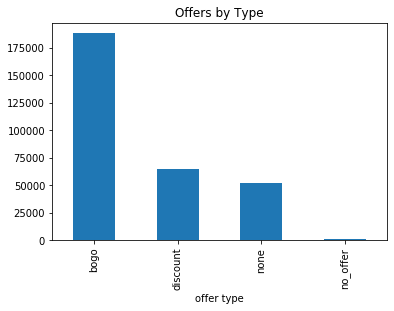

In [110]:
df['offer_type'].value_counts().plot(kind='bar', title='Offers by Type').set_xlabel('offer type')

In [9]:
df['offer_type'].value_counts()

bogo        188568
discount     64692
none         52088
no_offer      1186
Name: offer_type, dtype: int64

In [141]:
df.shape

(306534, 42)

In [111]:
df = df.drop_duplicates(subset='person')

In [112]:
df['offer_type'].value_counts()

bogo        9201
none        4191
discount    3464
no_offer     144
Name: offer_type, dtype: int64

In [113]:
df = df[['gender', 'income_binned', 'became_member_year''age_categories', 'offer_type']]

In [114]:
df = pd.get_dummies(df, columns=['age_categories', 'became_member_year''income_binned', 'gender'])

Text(0.5, 0, 'offer type')

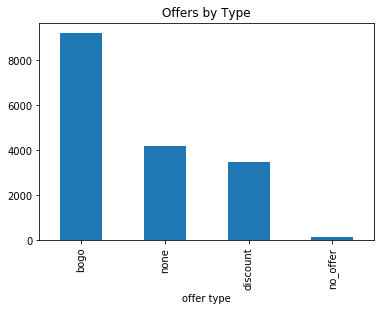

In [115]:
df['offer_type'].value_counts().plot(kind='bar', title='Offers by Type').set_xlabel('offer type')

In [116]:
# removing none and no_offer type to balance the dataset
#df = df[(df['offer_type'] != 'no_offer')]
df = df[(df['offer_type'] != 'none')]

Text(0.5, 0, 'offer type')

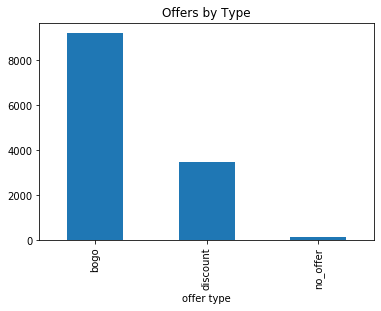

In [117]:
df['offer_type'].value_counts().plot(kind='bar', title='Offers by Type').set_xlabel('offer type')

In [118]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

X = df.drop('offer_type', axis=1)
y = df['offer_type']

le = LabelEncoder()
y = le.fit_transform(y)

In [56]:
X.shape

(12665, 28)

In [ ]:
#!pip install imbalanced-learn

In [81]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [82]:
X.shape

(27603, 28)

In [119]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, test_size=0.2)

In [39]:
from sklearn.svm import SVC

modelSVC = SVC()
modelSVC.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [40]:
prediction = modelSVC.predict(X_test)
accuracy_score(y_test, prediction)

0.5209201231660932

In [120]:
from sklearn.ensemble import RandomForestClassifier
modelRFC = RandomForestClassifier(n_estimators=10)
modelRFC.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [122]:
predictionRFC = modelRFC.predict(X_test)
print(
'accuracy_score: ', accuracy_score(y_test, predictionRFC),
'\nprecision_score: ', precision_score(y_test, predictionRFC, average=None),
'\nrecall_score: ', recall_score(y_test, predictionRFC, average=None),
'\nf1_score: ', f1_score(y_test, predictionRFC, average=None))

accuracy_score:  0.7197501951600312 
precision_score:  [0.72704612 0.60645161 0.        ] 
recall_score:  [0.96685083 0.13091922 0.        ] 
f1_score:  [0.82997392 0.21534937 0.        ]


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [123]:
from sklearn.ensemble import GradientBoostingClassifier

modelGBC = GradientBoostingClassifier()
modelGBC.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [124]:
predictGBC = modelGBC.predict(X_test)
accuracy_score(y_test, predictGBC)

0.7197501951600312

In [195]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

params = {
              "n_estimators": [50, 100, 150, 200],
              "learning_rate": [0.003, 0.03, 0.3, 1]
             }

scorer = make_scorer(accuracy_score)
clf = AdaBoostClassifier(random_state=7)

grid_obj = GridSearchCV(clf, params, scorer, verbose=10)
grid_fit = grid_obj.fit(X_train, y_train)
best_clf = grid_fit.best_estimator_
best_clf

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] learning_rate=0.003, n_estimators=50 ............................
[CV]  learning_rate=0.003, n_estimators=50, score=0.817, total=   0.6s
[CV] learning_rate=0.003, n_estimators=50 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  learning_rate=0.003, n_estimators=50, score=0.817, total=   0.5s
[CV] learning_rate=0.003, n_estimators=50 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV]  learning_rate=0.003, n_estimators=50, score=0.817, total=   0.6s
[CV] learning_rate=0.003, n_estimators=100 ...........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s


[CV]  learning_rate=0.003, n_estimators=100, score=0.817, total=   1.1s
[CV] learning_rate=0.003, n_estimators=100 ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.7s remaining:    0.0s


[CV]  learning_rate=0.003, n_estimators=100, score=0.817, total=   1.1s
[CV] learning_rate=0.003, n_estimators=100 ...........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s remaining:    0.0s


[CV]  learning_rate=0.003, n_estimators=100, score=0.817, total=   1.0s
[CV] learning_rate=0.003, n_estimators=150 ...........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.8s remaining:    0.0s


[CV]  learning_rate=0.003, n_estimators=150, score=0.817, total=   1.7s
[CV] learning_rate=0.003, n_estimators=150 ...........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    6.5s remaining:    0.0s


[CV]  learning_rate=0.003, n_estimators=150, score=0.817, total=   1.6s
[CV] learning_rate=0.003, n_estimators=150 ...........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    8.1s remaining:    0.0s


[CV]  learning_rate=0.003, n_estimators=150, score=0.817, total=   1.6s
[CV] learning_rate=0.003, n_estimators=200 ...........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    9.8s remaining:    0.0s


[CV]  learning_rate=0.003, n_estimators=200, score=0.817, total=   2.1s
[CV] learning_rate=0.003, n_estimators=200 ...........................
[CV]  learning_rate=0.003, n_estimators=200, score=0.817, total=   2.2s
[CV] learning_rate=0.003, n_estimators=200 ...........................
[CV]  learning_rate=0.003, n_estimators=200, score=0.817, total=   2.2s
[CV] learning_rate=0.03, n_estimators=50 .............................
[CV] . learning_rate=0.03, n_estimators=50, score=0.817, total=   0.6s
[CV] learning_rate=0.03, n_estimators=50 .............................
[CV] . learning_rate=0.03, n_estimators=50, score=0.817, total=   0.6s
[CV] learning_rate=0.03, n_estimators=50 .............................
[CV] . learning_rate=0.03, n_estimators=50, score=0.817, total=   0.6s
[CV] learning_rate=0.03, n_estimators=100 ............................
[CV]  learning_rate=0.03, n_estimators=100, score=0.817, total=   1.0s
[CV] learning_rate=0.03, n_estimators=100 ............................
[CV

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  1.1min finished


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.3,
                   n_estimators=100, random_state=7)

In [196]:
accuracy_score(y_test, best_clf.predict(X_test))

0.8253424657534246

In [86]:
#!pip install xgboost

     |████████████████████████████████| 829kB 1.3MB/s eta 0:00:01
  Stored in directory: /Users/tarasowski/Library/Caches/pip/wheels/51/10/c1/d7b4a0cd3e7a3391958df48d09724c3c37be36c22b24c5d9f9
Successfully built xgboost


In [88]:
from xgboost import XGBClassifier


model = XGBClassifier(max_depth=7, n_estimators=300, learning_rate=0.03, random_state=7)
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy * 100, 2)}%")

Accuracy: 71.58%


In [93]:
nr = 7
print('Customer attributes:', '\n', X_test.iloc[nr, :], '\n', 
      '\nPrediction (Offer): ', le.inverse_transform([y_pred[nr]])[0],
      '\nOriginal (Offer): ', le.inverse_transform([y_test[nr]])[0])

Customer attributes: 
 age_categories_10-19       0
age_categories_20-29       0
age_categories_30-39       0
age_categories_40-49       1
age_categories_50-59       0
age_categories_60-69       0
age_categories_70-79       0
age_categories_80-89       0
age_categories_Missing     0
income_binned_100k-109k    0
income_binned_110k-120k    0
income_binned_30k-39k      0
income_binned_40k-49k      0
income_binned_50k-59k      0
income_binned_60k-69k      1
income_binned_70k-79k      0
income_binned_80k-89k      0
income_binned_90k-99k      0
became_member_year_2013    0
became_member_year_2014    0
became_member_year_2015    0
became_member_year_2016    0
became_member_year_2017    0
became_member_year_2018    1
gender_F                   0
gender_M                   1
gender_N                   0
gender_O                   0
Name: 124938, dtype: uint8 
 
Prediction (Offer):  bogo 
Original (Offer):  bogo


In [248]:
def recommend(attributes, model):
    return le.inverse_transform(model.predict(attributes))

In [249]:
recommend(X_test.iloc[400:450, :], model)

array(['bogo', 'bogo', 'discount', 'bogo', 'bogo', 'discount', 'bogo',
       'discount', 'bogo', 'bogo', 'bogo', 'bogo', 'bogo', 'bogo', 'bogo',
       'bogo', 'bogo', 'bogo', 'bogo', 'bogo', 'bogo', 'bogo', 'bogo',
       'bogo', 'bogo', 'bogo', 'bogo', 'bogo', 'bogo', 'bogo', 'bogo',
       'bogo', 'bogo', 'bogo', 'bogo', 'bogo', 'bogo', 'bogo', 'bogo',
       'bogo', 'discount', 'bogo', 'bogo', 'discount', 'bogo', 'bogo',
       'bogo', 'bogo', 'bogo', 'bogo'], dtype=object)

In [255]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

print(f'{round(accuracy_score(y_test, model.predict(X_test)) * 100, 2)}%')

82.66%


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
